in this notebook i will create and test models 

In [1]:
import numpy as np
import pandas as pd 
import os 
import sys
import torch.nn as nn 
import matplotlib.pyplot as plt 

sys.path.append(os.path.abspath('..'))

In [2]:
import torch 

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {DEVICE} device")

Using cuda device


### prepare daat

In [3]:
path = os.path.join('..', 'dataset.csv')
df = pd.read_csv(path)
df

,Sentiment,Headline
0,0.00,employ who stole nearli 3m in wage from 157 wo...
1,0.50,huge new facebook data leak expos intim detail...
2,0.00,a caign ha acceler to turn a disus railway lin...
3,0.50,googl launch global human traffick helplin dat...
4,0.50,over 3m saudi women dont have id card saudi gr...
...,...,...
32152,0.00,neg on chambal advanta mitesh thacker
32153,1.00,small midcap stock may emerg outperform
32154,0.25,rupe slip against us dollar
32155,0.25,rupe weak against us dollar


### Index based Encoding

In [4]:
from utils import longest_sequence, Tokenizer
from sklearn.model_selection import train_test_split

# prepare data
X, y = df['Headline'].tolist(), df['Sentiment'].tolist()

# clean data
tokenizer = Tokenizer()
X = [tokenizer.clean_text(x) for x in X]

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# prepare tokens
MAX_TOKEN_NO = 1000
SEQUENCE_LEN = longest_sequence(X)

tokenizer.fit_on_sequences(X_train)
X_train = [tokenizer.ibe_text(text=text, max_token_no=MAX_TOKEN_NO, sequence_len=SEQUENCE_LEN) for text in X_train]
X_test = [tokenizer.ibe_text(text=text, max_token_no=MAX_TOKEN_NO, sequence_len=SEQUENCE_LEN) for text in X_test]
X_test[0]

[nltk_data] Downloading package wordnet to /home/kuba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[1,
 30,
 23,
 324,
 29,
 208,
 8,
 1,
 723,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.31186766765317325

In [6]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.32208513977730396

In [7]:
import torch 

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(58, 1)
        
    def forward(self, x):
        return self.linear(x)
    
reg = LinearRegressionModel()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.SGD(reg.parameters(), lr = 0.00001)

for epoch in range(10000):
    optimizer.zero_grad()
    
    y_pred = reg(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()

y_pred = reg(X_test_torch)
mae = criterion(y_pred, y_test_torch)
mae

tensor(1.9247, grad_fn=<MeanBackward0>)

### BOW

In [8]:
X, y = df['Headline'].tolist(), df['Sentiment'].tolist()

# clean data
tokenizer = Tokenizer()
X = [tokenizer.clean_text(x) for x in X]

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# # prepare tokens
MAX_TOKEN_NO = 1000

tokenizer.fit_on_sequences(X_train)
X_train = [tokenizer.bow_text(text=text, max_token_no=MAX_TOKEN_NO) for text in X_train]
X_test = [tokenizer.bow_text(text=text, max_token_no=MAX_TOKEN_NO) for text in X_test]
X_test[0]

[0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [9]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.2463026015451476

In [10]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.2828664712153518

In [11]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(MAX_TOKEN_NO, 1)
        
    def forward(self, x):
        return self.linear(x)
    
reg = LinearRegressionModel()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.SGD(reg.parameters(), lr = 0.001)

for epoch in range(5000):
    optimizer.zero_grad()
    
    y_pred = reg(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()

y_pred = reg(X_test_torch)
mae = criterion(y_pred, y_test_torch)
mae

tensor(0.2896, grad_fn=<MeanBackward0>)

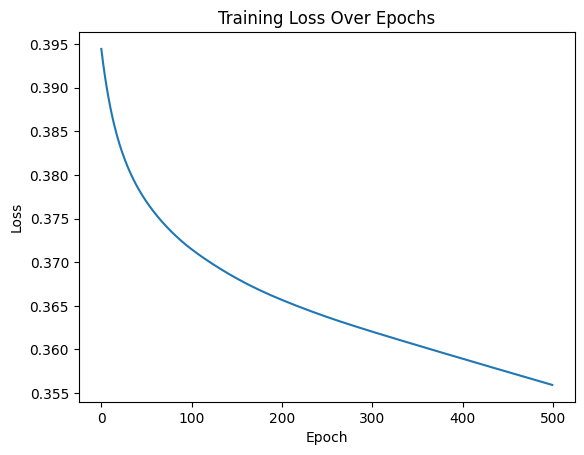

tensor(0.3560, grad_fn=<MeanBackward0>)

In [12]:
class nnModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(1000, 250),
            nn.Linear(250, 50),
            nn.Linear(50, 1)
        )
        
        
    def forward(self, x):
        return self.stack(x)
    
model = nnModel()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

losses = []
EPOCHS = 500
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    y_pred = model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

plt.plot(range(EPOCHS), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

y_pred = model(X_test_torch)
mae = criterion(y_pred, y_test_torch)
mae

### BOW 5K

In [13]:
X, y = df['Headline'].tolist(), df['Sentiment'].tolist()

# clean data
tokenizer = Tokenizer()
X = [tokenizer.clean_text(x) for x in X]

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# # prepare tokens
MAX_TOKEN_NO = 5000

tokenizer.fit_on_sequences(X_train)
X_train = [tokenizer.bow_text(text=text, max_token_no=MAX_TOKEN_NO) for text in X_train]
X_test = [tokenizer.bow_text(text=text, max_token_no=MAX_TOKEN_NO) for text in X_test]
X_test[0]

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.23945299080361904

In [15]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=7).fit(X_train, y_train)
y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.2973002546789861

In [16]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor().fit(X_train, y_train)
y_pred = dt.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.19850029668845803

### word embading

In [17]:
import spacy 

try:
    nlp = spacy.load('en_core_web_md')
except:
    from spacy.cli import download
    download('en_core_web_md')
    nlp = spacy.load('en_core_web_md')

# prepare data
X, y = df['Headline'].tolist(), df['Sentiment'].tolist()

# clean data
tokenizer = Tokenizer()
X = [tokenizer.clean_text(x) for x in X]
X = [nlp(x).vector for x in X]

In [18]:
# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.28129154443740845

In [20]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor().fit(X_train, y_train)
y_pred = dt.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

0.3039095168257262

In [21]:

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

X_train_torch.shape, y_train_torch.shape

/tmp/ipykernel_392063/120797040.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_train_torch = torch.tensor(X_train, dtype=torch.float32)


(torch.Size([24117, 300]), torch.Size([24117, 1]))

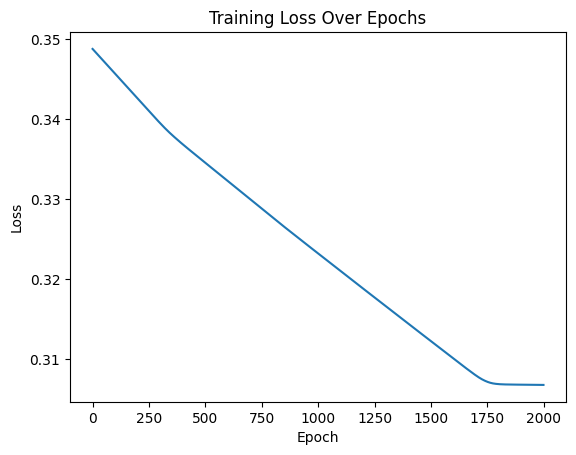

tensor(0.3077, grad_fn=<MeanBackward0>)

In [22]:
class nnModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(), 
            nn.Linear(10, 1)
        )
        
        
    def forward(self, x):
        return self.stack(x)
    
model = nnModel()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

losses = []
EPOCHS = 2000
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    y_pred = model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

plt.plot(range(EPOCHS), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

y_pred = model(X_test_torch)
MAE = torch.nn.L1Loss()
mae = MAE(y_pred, y_test_torch)
mae